In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

from sktime.transformations.series.adapt import PandasTransformAdaptor
from sktime.utils import plotting
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.croston import Croston
from sktime.datasets import load_PBS_dataset
from sktime.forecasting.arima import AutoARIMA
from sktime.datatypes import get_examples
from sktime.datatypes import check_raise
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series
from sktime.transformations.series.difference import Differencer
from sktime.transformations.compose import InvertTransform
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.acf import AutoCorrelationTransformer
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from statsmodels.tsa.stattools import adfuller
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

tf.keras.backend.clear_session()
tf.compat.v1.disable_eager_execution() #IF ERROR, UNCOMMENT
# Any results you write to the current directory are saved as output.

patience = 25
season_number_of_points = 12
sp = season_number_of_points
timestamp = season_number_of_points
forecastingHorizon = 6
train_ratio = 0.8
usePipe = True
useValidation = True
progressiveForecast = True

if (progressiveForecast):
    indirectForecastingHorizon = forecastingHorizon
    forecastingHorizon = 1

2023-01-25 14:50:04.771544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/sktime/utils/validation/_dependencies.py:143: UserWarning: No module named 'pmdarima'. 'pmdarima' is a soft dependency and not included in the base sktime installation. Please run: `pip install pmdarima` to install the pmdarima package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)


In [2]:
df = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])
# productNumber = "26855"
# datasetTarget="/home/esteban/Documents/Optimix/DeepAR/tools/correctedsupplyProduct_"+productNumber+".csv"
# df = pd.read_csv(datasetTarget, header=0, index_col=0)
# df.reset_index(inplace=True)
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


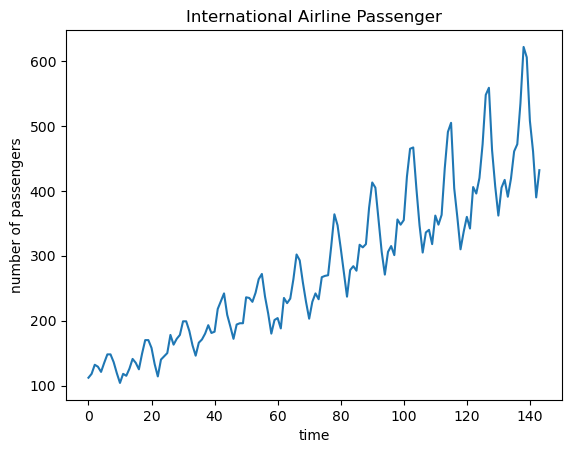

In [3]:
dataset = df.iloc[:,1].values
plt.plot(dataset)
plt.xlabel('time')
plt.ylabel('number of passengers')
plt.title('International Airline Passenger')
plt.show()

In [4]:
train_size = int(len(dataset)*train_ratio)
test_size = len(dataset) - train_size
# print(dataset)
trainDataset = dataset[:train_size]
testDataset = dataset[train_size:len(dataset)]
print('train_size : {}, test_size : {}, total_size : {}'.format(len(trainDataset),len(testDataset),len(dataset)))

train_size : 115, test_size : 29, total_size : 144


In [5]:
if (usePipe):
    pipeTrain = TransformerPipeline(steps=[
            ("imputer", Imputer(method="mean")),
            ("boxcox", BoxCoxTransformer()),
            ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
#             ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
#             ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#             ("differencer", Differencer(lags=1, na_handling='fill_zero')),
#             ("differencer", Differencer(lags=12, na_handling='fill_zero')),
#             ("forecaster", NaiveForecaster(strategy="drift")),
    ])
    pipeTest = TransformerPipeline(steps=[
            ("imputer", Imputer(method="mean")),
            ("boxcox", BoxCoxTransformer()),
            ("minmaxscaler", TabularToSeriesAdaptor(MinMaxScaler())),
#             ("deseasonalize", Deseasonalizer(model="additive", sp=sp)),
#             ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#             ("differencer", Differencer(lags=1, na_handling='fill_zero')),
#             ("differencer", Differencer(lags=12, na_handling='fill_zero')),
#             ("forecaster", NaiveForecaster(strategy="drift")),
    ])
    transformedTrainDataset = pipeTrain.fit_transform(trainDataset)
    transformedTestDataset = pipeTest.fit_transform(testDataset)
    
else:
    scalerTrain = MinMaxScaler(feature_range=(0,1))
    scalerTest = MinMaxScaler(feature_range=(0,1))
    transformedTrainDataset = scalerTrain.fit_transform(trainDataset.reshape(-1, 1))
    transformedTestDataset = scalerTest.fit_transform(testDataset.reshape(-1, 1))

print("transformedTrainDataset : ", transformedTrainDataset.shape, "transformedTestDataset : ", transformedTestDataset.shape)

transformedTrainDataset :  (115, 1) transformedTestDataset :  (29, 1)


In [6]:
dataX = []
dataY = []
for i in range(len(transformedTrainDataset)-timestamp-forecastingHorizon+1):
    a = transformedTrainDataset[i:(i+timestamp),0]
    b = transformedTrainDataset[(i+timestamp):(i+timestamp+forecastingHorizon),0]
    dataX.append(a)
    dataY.append(b)
transformedTrainDatasetInputs = np.array(dataX)
transformedTrainDatasetOutputs = np.array(dataY)

dataX = []
dataY = []
for i in range(len(transformedTestDataset)-timestamp-forecastingHorizon+1):
    a = transformedTestDataset[i:(i+timestamp),0]
    b = transformedTestDataset[(i+timestamp):(i+timestamp+forecastingHorizon),0]
    dataX.append(a)
    dataY.append(b)
transformedTestDatasetInputs = np.array(dataX)
transformedTestDatasetOutputs = np.array(dataY)
print(len(transformedTrainDataset)-timestamp-forecastingHorizon, len(transformedTestDataset)-timestamp-forecastingHorizon)

if (progressiveForecast):
    dataX = []
    dataY = []
    for i in range(len(transformedTestDataset)-timestamp-indirectForecastingHorizon+1):
        a = transformedTestDataset[i:(i+timestamp),0]
        b = transformedTestDataset[(i+timestamp):(i+timestamp+indirectForecastingHorizon),0]
        dataX.append(a)
        dataY.append(b)
    indirectTransformedTestDatasetInputs = np.array(dataX)
    indirectTransformedTestDatasetOutputs = np.array(dataY)

102 16


In [7]:
print('transformedTrainDatasetInputs shape : {}, transformedTestDatasetInputs original shape : {}'.format(transformedTrainDatasetInputs.shape,transformedTestDatasetInputs.shape))
print('transformedTrainDatasetOutputs shape : {}, transformedTestDatasetOutputs original shape : {}'.format(transformedTrainDatasetOutputs.shape,transformedTestDatasetOutputs.shape))

reshapedTransformedTrainDatasetInputs = np.reshape(transformedTrainDatasetInputs,(transformedTrainDatasetInputs.shape[0],1,transformedTrainDatasetInputs.shape[1])) #(number of points, features number, lookback)
reshapedTransformedTestDatasetInputs = np.reshape(transformedTestDatasetInputs,(transformedTestDatasetInputs.shape[0],1,transformedTestDatasetInputs.shape[1]))

reshapedTransformedTrainDatasetOutputs = np.reshape(transformedTrainDatasetOutputs,(transformedTrainDatasetOutputs.shape[0],transformedTrainDatasetOutputs.shape[1])) #(number of points, features number, lookback)
reshapedTransformedTestDatasetOutputs = np.reshape(transformedTestDatasetOutputs,(transformedTestDatasetOutputs.shape[0],transformedTestDatasetOutputs.shape[1]))

if (progressiveForecast):
    reshapedIndirectTransformedTestDatasetOutputs = np.reshape(indirectTransformedTestDatasetOutputs,(indirectTransformedTestDatasetOutputs.shape[0],indirectTransformedTestDatasetOutputs.shape[1]))
print('\nreshapedTransformedTrainDatasetInputs shape : {}, reshapedTransformedTestDatasetInputs shape : {}'.format(reshapedTransformedTrainDatasetInputs.shape,reshapedTransformedTestDatasetInputs.shape))
print('reshapedTransformedTrainDatasetOutputs shape : {}, reshapedTransformedTestDatasetOutputs shape : {}'.format(reshapedTransformedTrainDatasetOutputs.shape,reshapedTransformedTestDatasetOutputs.shape))

# print(testDataset)
# # print(reshapedTransformedTestDatasetInputs)
# for j in range (reshapedTransformedTestDatasetInputs.shape[0]):
#     print(pipeTest.inverse_transform(reshapedTransformedTestDatasetInputs[j,:,:].reshape(-1,1)).reshape(-1,timestamp))

transformedTrainDatasetInputs shape : (103, 12), transformedTestDatasetInputs original shape : (17, 12)
transformedTrainDatasetOutputs shape : (103, 1), transformedTestDatasetOutputs original shape : (17, 1)

reshapedTransformedTrainDatasetInputs shape : (103, 1, 12), reshapedTransformedTestDatasetInputs shape : (17, 1, 12)
reshapedTransformedTrainDatasetOutputs shape : (103, 1), reshapedTransformedTestDatasetOutputs shape : (17, 1)


2023-01-24 14:52:21.408004: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 14:52:21.408576: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Train on 103 samples, validate on 17 samples
Epoch 1/1000


2023-01-24 14:52:21.665328: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-24 14:52:21.674739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


 74/103 [====================>.........] - ETA: 0s - loss: 0.1788

/home/esteban/anaconda3/envs/Keras/lib/python3.10/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


103/103 [==============================] - 1s 4ms/sample - loss: 0.1605 - val_loss: 0.1662
Epoch 2/1000
103/103 [==============================] - 0s 2ms/sample - loss: 0.0734 - val_loss: 0.0915
Epoch 3/1000
103/103 [==============================] - 0s 2ms/sample - loss: 0.0282 - val_loss: 0.0573
Epoch 4/1000
103/103 [==============================] - 0s 2ms/sample - loss: 0.0115 - val_loss: 0.0451
Epoch 5/1000
103/103 [==============================] - 0s 2ms/sample - loss: 0.0076 - val_loss: 0.0423
Epoch 6/1000
103/103 [==============================] - 0s 2ms/sample - loss: 0.0069 - val_loss: 0.0409
Epoch 7/1000
103/103 [==============================] - 0s 2ms/sample - loss: 0.0067 - val_loss: 0.0401
Epoch 8/1000
103/103 [==============================] - 0s 2ms/sample - loss: 0.0067 - val_loss: 0.0396
Epoch 9/1000
103/103 [==============================] - 0s 2ms/sample - loss: 0.0066 - val_loss: 0.0392
Epoch 10/1000
103/103 [==============================] - 0s 2ms/sample - loss

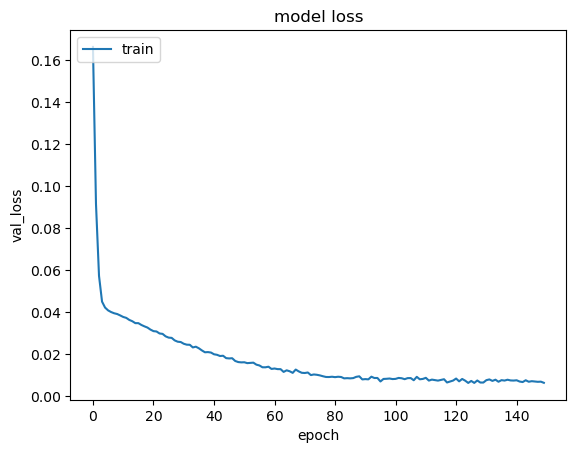

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5760      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# print(trainY.shape[2])
# model
model = Sequential()
# model.add(Dense(32))
# model.add(LSTM(32)) # 10 lstm neuron(block)
model.add(LSTM(32, input_shape=(1, timestamp))) # 10 lstm neuron(block)
model.add(Dense(forecastingHorizon))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)) #'adam'
# history = model.fit(trainX, trainY, epochs=50, batch_size=1)
# print(model.output_shape)
if (useValidation):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss",min_delta=0.00005)
    ]
    history = model.fit(reshapedTransformedTrainDatasetInputs, reshapedTransformedTrainDatasetOutputs, epochs=1000, batch_size=1, validation_data=(reshapedTransformedTestDatasetInputs,reshapedTransformedTestDatasetOutputs), callbacks=callbacks)
    plt.title('model loss')
    try :
        plt.plot(history.history['val_loss'])
        plt.ylabel('val_loss')
    except : 
        plt.plot(history.history['loss'])
        plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
else :
    callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=patience, monitor="loss",min_delta=0.00005)
    ]
    history = model.fit(reshapedTransformedTrainDatasetInputs, reshapedTransformedTrainDatasetOutputs, epochs=1000, batch_size=1, callbacks=callbacks)
    plt.title('model loss')
    plt.plot(history.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
# tf.keras.utils.plot_model(model, show_shapes=True)
print(model.summary())

In [3]:
# print(indirectTransformedTestDatasetInputs)
# print(indirectTransformedTestDatasetOutputs)
if (progressiveForecast):
    TransformedTrainDatasetPredictions = model.predict(reshapedTransformedTrainDatasetInputs)
    finalPredictionOutput = []
    for indexTimeSerie in range (0,len(indirectTransformedTestDatasetInputs)):
        currentInputsArray = indirectTransformedTestDatasetInputs[indexTimeSerie]
        predictionOutput = []
        for i in range (0,indirectForecastingHorizon,1):
#             print(currentInputsArray)
#             print(np.reshape(currentInputsArray,(1,1,currentInputsArray.shape[0])).shape)
#             print(reshapedTransformedTrainDatasetInputs.shape)
            currentOutput = model.predict(np.reshape(currentInputsArray,(1,1,currentInputsArray.shape[0])))
#             print(currentOutput)
#             print(currentOutput[0][0])
            currentInputsArray = np.delete(currentInputsArray, 0)
            currentInputsArray = np.append(currentInputsArray,currentOutput[0][0])
#             print(type(predictionOutput))
            predictionOutput.append(currentOutput[0][0])
        finalPredictionOutput.append(predictionOutput)
    TransformedTestDatasetPredictions = np.array(finalPredictionOutput)
#     reshapedFinalPredictionOutput = finalPredictionOutput.reshape(finalPredictionOutput.shape[0],1,finalPredictionOutput.shape[1])
#     print(np.array(finalPredictionOutput).shape)
#     print(indirectTransformedTestDatasetOutputs.shape)
    print("Progressive Forecasting has been used")
else :
    TransformedTrainDatasetPredictions = model.predict(reshapedTransformedTrainDatasetInputs)
    TransformedTestDatasetPredictions = model.predict(reshapedTransformedTestDatasetInputs) 

NameError: name 'model' is not defined

In [10]:


# print(TransformedTrainDatasetPredictions.shape, TransformedTestDatasetPredictions.shape)
if usePipe :
#     print(TrainDatasetInputs)
#     print(reshapedTransformedTrainDatasetInputs.shape, reshapedTransformedTrainDatasetInputs.reshape(-1,1).shape)
    TrainDatasetInputs = pipeTrain.inverse_transform(reshapedTransformedTrainDatasetInputs.reshape(-1,1)).reshape(-1,timestamp)
    TrainDatasetOutputs = pipeTrain.inverse_transform(np.array([reshapedTransformedTrainDatasetOutputs]).reshape(-1,1)).reshape(-1,forecastingHorizon)
    
    TestDatasetInputs = pipeTest.inverse_transform(reshapedTransformedTestDatasetInputs.reshape(-1,1)).reshape(-1,timestamp)
    if (progressiveForecast):
        TestDatasetOutputs = pipeTest.inverse_transform(np.array([reshapedIndirectTransformedTestDatasetOutputs]).reshape(-1,1)).reshape(-1,indirectForecastingHorizon)
        TestDatasetPredictions = pipeTest.inverse_transform(TransformedTestDatasetPredictions.reshape(-1,1)).reshape(-1,indirectForecastingHorizon)
    else:
        TestDatasetOutputs = pipeTest.inverse_transform(np.array([reshapedTransformedTestDatasetOutputs]).reshape(-1,1)).reshape(-1,forecastingHorizon)
        TestDatasetPredictions = pipeTest.inverse_transform(TransformedTestDatasetPredictions.reshape(-1,1)).reshape(-1,forecastingHorizon)
    TrainDatasetPredictions = pipeTrain.inverse_transform(TransformedTrainDatasetPredictions.reshape(-1,1)).reshape(-1,forecastingHorizon)

    

else :
    TrainDatasetInputs = scalerTrain.inverse_transform(reshapedTransformedTrainDatasetInputs.reshape(-1,1)).reshape(-1,timestamp)
    TrainDatasetOutputs = scalerTrain.inverse_transform(reshapedTransformedTrainDatasetOutputs.reshape(-1,1)).reshape(-1,forecastingHorizon)
    TrainDatasetPredictions = scalerTrain.inverse_transform(TransformedTrainDatasetPredictions.reshape(-1,1)).reshape(-1,forecastingHorizon)
    TestDatasetInputs = scalerTest.inverse_transform(reshapedTransformedTestDatasetInputs.reshape(-1,1)).reshape(-1,timestamp)
    if (progressiveForecast):
        TestDatasetOutputs = scalerTest.inverse_transform(reshapedIndirectTransformedTestDatasetOutputs.reshape(-1,1)).reshape(-1,indirectForecastingHorizon)
        TestDatasetPredictions = scalerTest.inverse_transform(TransformedTestDatasetPredictions.reshape(-1,1)).reshape(-1,indirectForecastingHorizon)
    else : 
        TestDatasetOutputs = scalerTest.inverse_transform(reshapedTransformedTestDatasetOutputs.reshape(-1,1)).reshape(-1,forecastingHorizon)
        TestDatasetPredictions = scalerTest.inverse_transform(TransformedTestDatasetPredictions.reshape(-1,1)).reshape(-1,forecastingHorizon)

    
print(TrainDatasetInputs.shape, TrainDatasetOutputs.shape, TrainDatasetPredictions.shape, TestDatasetInputs.shape, TestDatasetOutputs.shape, TestDatasetPredictions.shape)

(103, 12) (103, 1) (103, 1) (17, 12) (12, 6) (12, 6)


In [11]:
trainScore = math.sqrt(mean_squared_error(TrainDatasetOutputs, TrainDatasetPredictions))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(TestDatasetOutputs, TestDatasetPredictions))
print('Test Score: %.2f RMSE' % (testScore))
trainScore2 = math.sqrt(mean_absolute_percentage_error(TrainDatasetOutputs, TrainDatasetPredictions))
print('Train Score: %.2f MAPE' % (trainScore2))
testScore2 = math.sqrt(mean_absolute_percentage_error(TestDatasetOutputs, TestDatasetPredictions))
print('Test Score: %.2f MAPE' % (testScore2))

# for i in range (0,6,1):
#     print(math.sqrt(mean_absolute_percentage_error(TestDatasetOutputs[:,i], TestDatasetPredictions[:,i])))
    
# for i in range (0,6,1):
#     print(math.sqrt(mean_absolute_percentage_error(TestDatasetOutputs[:,i], TestDatasetPredictions[:,i])))

Train Score: 13.55 RMSE
Test Score: 29.50 RMSE
Train Score: 0.21 MAPE
Test Score: 0.23 MAPE


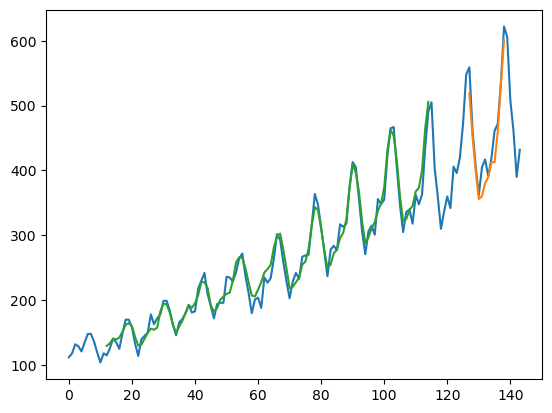

In [12]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot = [np.nan] * len(trainPredictPlot)
# print(len(TrainDatasetPredictions), len(trainPredict))
trainPredictPlot[timestamp:len(TrainDatasetPredictions)+timestamp] = TrainDatasetPredictions[:,0]
forecastingDepthIndexToPlot = 0
testPredictPlot = np.empty_like(dataset)
testPredictPlot = [np.nan] * len(testPredictPlot)
testPredictPlot[len(TrainDatasetPredictions)+(timestamp*2)+forecastingHorizon+forecastingDepthIndexToPlot-1:len(dataset)-1] = TestDatasetPredictions[:,forecastingDepthIndexToPlot]
# print(len(TestDatasetPredictions[:,0]),len(trainPredict)+(timestamp*2)+1+forecastingHorizon, len(dataset)-1)

plt.plot(dataset)
plt.plot(testPredictPlot)
plt.plot(trainPredictPlot)
plt.show()


In [13]:
if (not(progressiveForecast)):
    for index in range (len(TrainDatasetPredictions)):

        individualTrainInputsPlot = np.empty_like(dataset)
        individualTrainInputsPlot = [np.nan] * len(individualTrainInputsPlot)
        individualTrainInputsPlot[index:timestamp+index] = TrainDatasetInputs[index]

        individualTrainPredictPlot = np.empty_like(dataset)
        individualTrainPredictPlot = [np.nan] * len(individualTrainPredictPlot)
        individualTrainPredictPlot[index+timestamp:timestamp+index+forecastingHorizon] = TrainDatasetPredictions[index]

        plt.plot(dataset)
        plt.plot(individualTrainPredictPlot)
        plt.plot(individualTrainInputsPlot)
        plt.show()

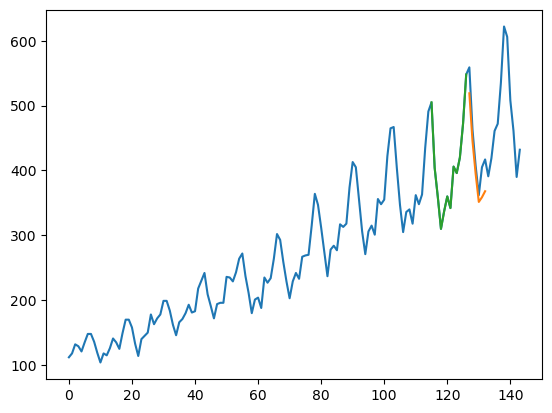

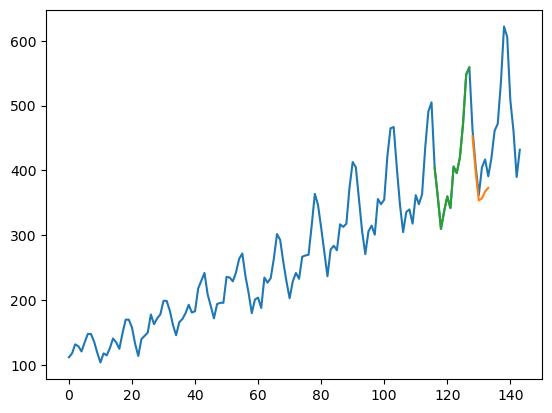

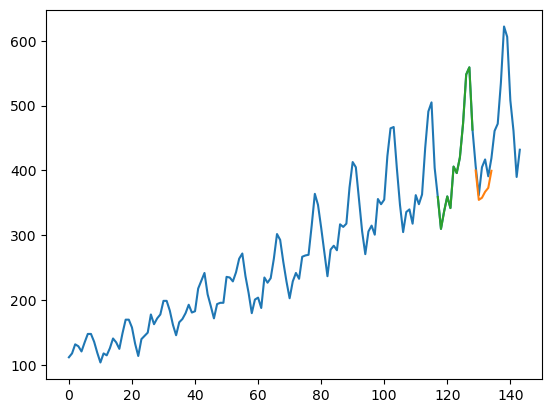

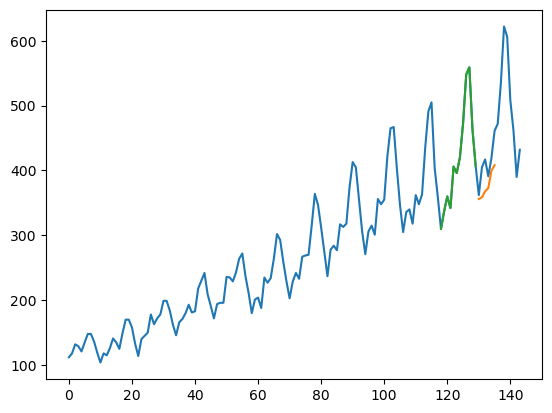

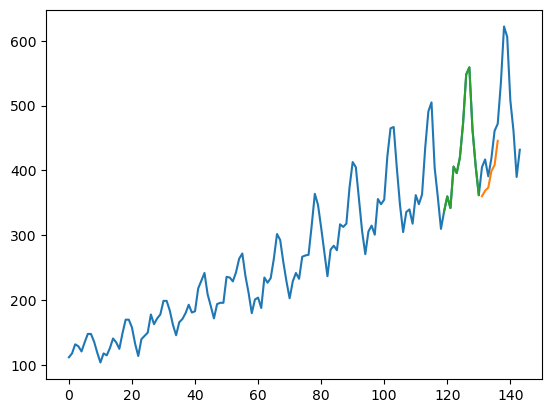

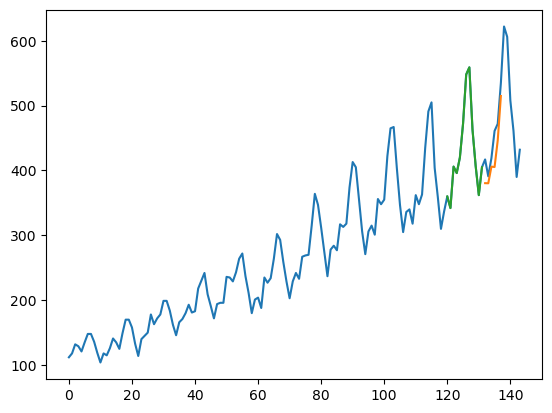

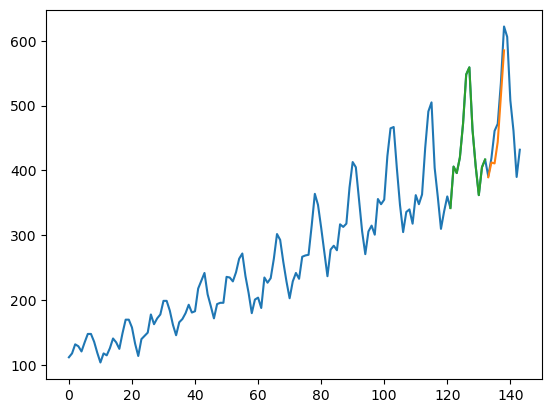

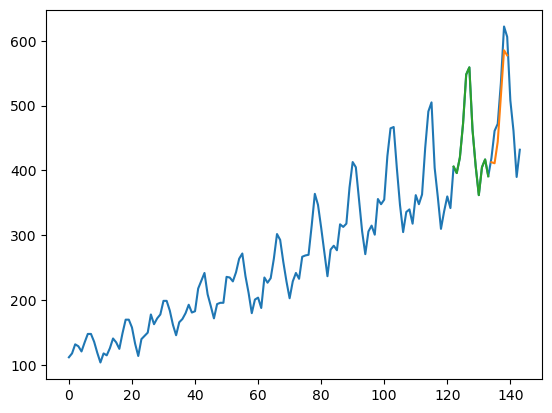

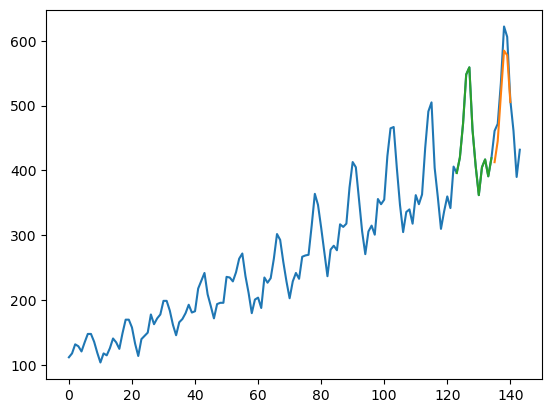

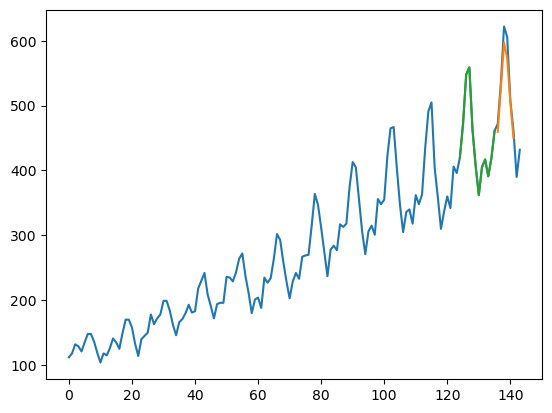

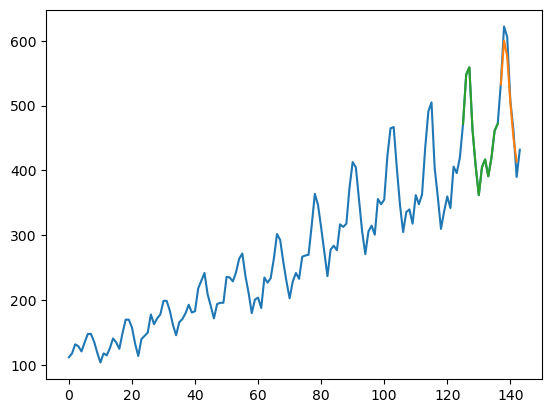

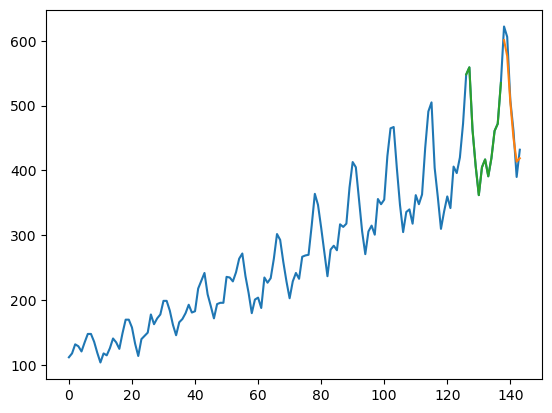

In [14]:
for index in range (len(TestDatasetPredictions)):

    individualTestInputsPlot = np.empty_like(dataset)
    individualTestInputsPlot = [np.nan] * len(individualTestInputsPlot)
    individualTestInputsPlot[len(TrainDatasetPredictions)+index+timestamp+forecastingHorizon-1:len(TrainDatasetPredictions)+index+timestamp*2+forecastingHorizon-1] = TestDatasetInputs[index]
    individualTestPredictPlot = np.empty_like(dataset)
    individualTestPredictPlot = [np.nan] * len(individualTestPredictPlot)
    individualTestPredictPlot[len(TrainDatasetPredictions)+index+timestamp*2+forecastingHorizon-1:len(TrainDatasetPredictions)+index+2*timestamp+2*forecastingHorizon-1] = TestDatasetPredictions[index]
#     print(index)
#     print(individualTestInputsPlot)
#     print(len(TrainDatasetPredictions)+index+timestamp*2+forecastingHorizon,len(TrainDatasetPredictions)+index+2*timestamp+2*forecastingHorizon)
    plt.plot(dataset)
    plt.plot(individualTestPredictPlot)
    plt.plot(individualTestInputsPlot)
    plt.show()

In [4]:
[1].append([1,2])